In [1]:
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [2]:
def generate_data(size, std, outliers_probability, polynom_coefficients):
    trend = np.polyval(polynom_coefficients, np.arange(size))
    np.random.seed(1234)
    noise = np.random.normal(0, std, size)
    data = trend + noise
    mask = np.random.rand(size) <= outliers_probability
    anomalies = np.random.normal(0, 3 * std, np.sum(mask))
    data[mask] += anomalies

    return pd.Series(data)

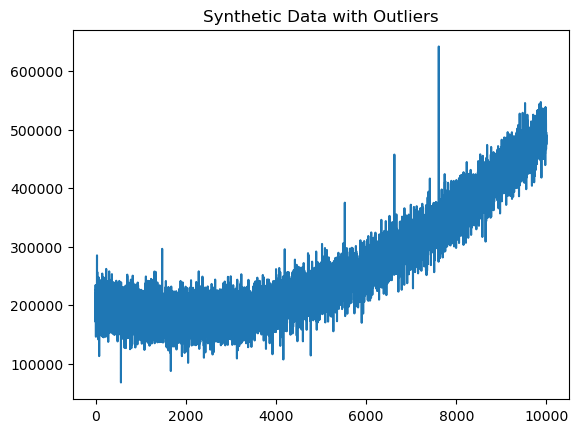

In [3]:
size = 10000
std = 24000
outliers_probability = 0.004
polynom_coefficients = np.array([0.005, -20, 200000])
data = generate_data(size, std, outliers_probability, polynom_coefficients)
plt.plot(data)
plt.title('Synthetic Data with Outliers')
plt.show()

In [4]:
data = data.reset_index(name='y')
data = data.rename(columns={'index': 'X'})
data

,X,y
0,0,211314.443930
1,1,171396.588327
2,2,234344.987242
3,3,192436.399494
4,4,182625.950399
...,...,...
9995,9995,474445.740706
9996,9996,480989.253368
9997,9997,474500.988353
9998,9998,487895.385599


In [5]:
def sliding_window_iqr(sample, window_size, min_threshold=1, max_threshold=2):
    min_distance = np.inf
    thresholds = np.round(np.arange(min_threshold, max_threshold + 0.1, 0.1), 2)
    for threshold in thresholds:
        sample_copy = sample.copy()
        y_copy = sample_copy.y.values
        for i in range(len(sample_copy) - window_size + 1):
            current_window = y_copy[i: i + window_size]
            current_window_q1 = np.percentile(current_window, 25)
            current_window_q3 = np.percentile(current_window, 75)
            current_window_iqr = current_window_q3 - current_window_q1
            if y_copy[i] > current_window_q3 + threshold * current_window_iqr or y_copy[
                i] < current_window_q1 - threshold * current_window_iqr:
                y_copy[i] = np.median(current_window)
        for i in range(len(sample_copy) - window_size + 1, len(sample_copy)):
            if y_copy[i] > current_window_q3 + threshold * current_window_iqr or y_copy[
                i] < current_window_q1 - threshold * current_window_iqr:
                y_copy[i] = np.median(current_window)
        polynomial_model = Polynomial.fit(sample_copy.X, sample_copy.y, 2)
        calculated_coefs = polynomial_model.convert().coef
        sc = StandardScaler()
        ideal_coefs_scaled = sc.fit_transform(np.array(polynom_coefficients).reshape(1, -1))
        calculated_coefs_scaled = sc.transform(np.array(calculated_coefs).reshape(1, -1))
        current_distance = np.linalg.norm(ideal_coefs_scaled - calculated_coefs_scaled)
        if current_distance < min_distance:
            min_distance = current_distance
            best_threshold = threshold
            new_sample = sample_copy.copy()

    return best_threshold, new_sample

In [6]:
threshold, data = sliding_window_iqr(data, 8)
print(f'Best threshold: {threshold}')

Best threshold: 1.0


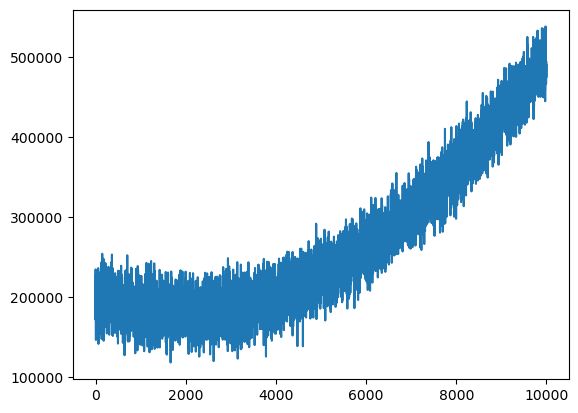

In [7]:
plt.plot(data.y);

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.X.values.reshape(-1, 1), data.y, test_size=0.1,
                                                    random_state=1234)
polynomial_regression = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polynomial_regression.fit(X_train, y_train)
predictions = polynomial_regression.predict(X_test)
print(f'R-squared value: {polynomial_regression.score(X_test, y_test)}')

R-squared value: 0.956035138087353


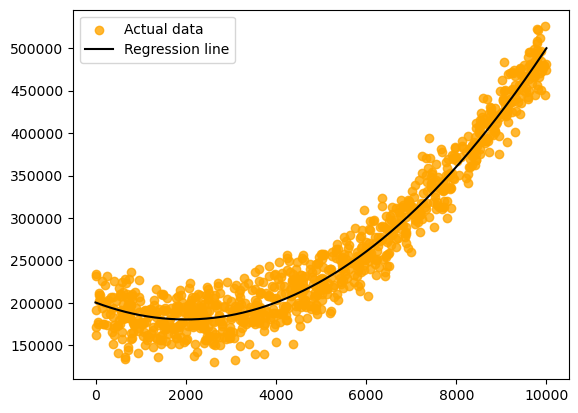

In [9]:
plt.scatter(X_test, y_test, label='Actual data', alpha=0.8, color='orange')
predictions = polynomial_regression.predict(data.X.values.reshape(-1, 1))
plt.plot(data.X, predictions, label='Regression line', color='black')
plt.legend()
plt.show()

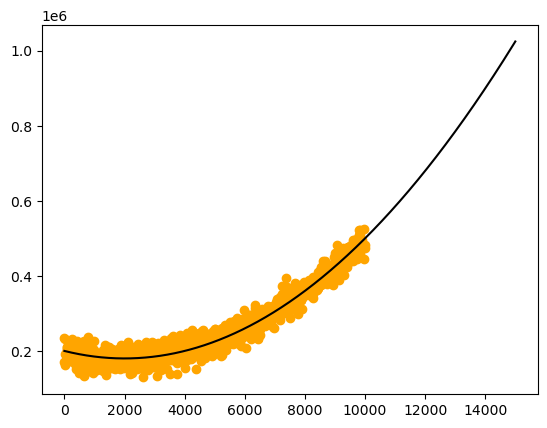

In [10]:
X_extended = np.arange(0, data.X.max() + 0.5 * size)
X_future = X_extended.reshape(-1, 1)
extended_predictions = polynomial_regression.predict(X_future)
plt.plot(X_future, extended_predictions, color='black')
plt.scatter(X_test, y_test, color='orange')
plt.show()

In [11]:
print(f'Mean: {extended_predictions.mean():.2f}')
print(f'Standard deviation: {extended_predictions.std():.2f}')

Mean: 425117.56
Standard deviation: 252049.89
